# Klasifikasi Gambar Sampah Rumah Tangga Menggunakan Convolutional Neural Network (CNN)
- **Nama:** M Faiq Rofifi
- **Email:** mfaiqrofifi@gmail.com
- **ID Dicoding:** M Faiq Rofifi

## Ringkasan Proyek

- Proyek ini bertujuan membangun model klasifikasi gambar sampah rumah tangga menggunakan CNN (Convolutional Neural Network).
- Model dikembangkan dengan framework TensorFlow dan Keras.
- Dataset yang digunakan berasal dari Kaggle: Garbage Classification Dataset.
- Dataset asli memiliki 12 kelas dan telah direstrukturisasi menjadi 3 kelas utama.
- Proses augmentasi dilakukan untuk memperkaya data latih dan mengurangi overfitting.
- Model dilatih hingga mencapai akurasi >85% pada data validasi dan pengujian.

## Struktur Label Akhir (3 Kelas) Source Dataset [garbage-classification](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)

- `domestic_textile`: gabungan dari `clothes`, `shoes`, `biological`
- `recyclables`: gabungan dari `plastic`, `metal`, `paper`, `cardboard`, `brown-glass`, `white-glass`, `green-glass`
- `residual_special`: gabungan dari `trash`, `battery`

## Struktur Dataset

- Dataset dibagi menjadi:
  - `train/` untuk pelatihan model
  - `val/` untuk validasi model
  - `test/` untuk pengujian akhir model
- Semua data disusun ulang ke dalam 3 folder sesuai label akhir.

## Ekspor Model

- Model diekspor ke dalam 3 format:
  - `SavedModel` (untuk deployment di server)
  - `TFLite` (untuk perangkat mobile/embedded)
  - `TFJS` (untuk aplikasi berbasis web)
- Disertakan pula file `label.txt` untuk interpretasi hasil prediksi.

## Import Semua Packages/Library yang Digunakan

In [1]:
# STEP 1: Import libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [ ]:
from tensorflow.keras.preprocessing import image

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfaiqrofifi","key":"06ccbe8fb94e3d2fe5c0cc52226f5f57"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mostafaabla/garbage-classification
!unzip garbage-classification.zip -d /content/

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/garbage_classification/paper/paper381.jpg  
  inflating: /content/garbage_classification/paper/paper382.jpg  
  inflating: /content/garbage_classification/paper/paper383.jpg  
  inflating: /content/garbage_classification/paper/paper384.jpg  
  inflating: /content/garbage_classification/paper/paper385.jpg  
  inflating: /content/garbage_classification/paper/paper386.jpg  
  inflating: /content/garbage_classification/paper/paper387.jpg  
  inflating: /content/garbage_classification/paper/paper388.jpg  
  inflating: /content/garbage_classification/paper/paper389.jpg  
  inflating: /content/garbage_classification/paper/paper39.jpg  
  inflating: /content/garbage_classification/paper/paper390.jpg  
  inflating: /content/garbage_classification/paper/paper391.jpg  
  inflating: /content/garbage_classification/paper/paper392.jpg  
  inflating: /content/garbage_classification/paper/paper393.jpg  
  inflating: /cont

In [6]:
original_dir = '/content/garbage_classification'

print("Jumlah gambar per kelas:")
total_images = 0
for cls in sorted(os.listdir(original_dir)):
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):
        num_images = len([name for name in os.listdir(cls_path) if name.lower().endswith(('.jpg', '.png'))])
        print(f"{cls:<15}: {num_images} gambar")
        total_images += num_images

print(f"\nTotal seluruh gambar: {total_images} gambar\n")

Jumlah gambar per kelas:
battery        : 945 gambar
biological     : 985 gambar
brown-glass    : 607 gambar
cardboard      : 891 gambar
clothes        : 5325 gambar
green-glass    : 629 gambar
metal          : 769 gambar
paper          : 1050 gambar
plastic        : 865 gambar
shoes          : 1977 gambar
trash          : 697 gambar
white-glass    : 775 gambar

Total seluruh gambar: 15515 gambar



### Data Preprocessing

### Data Splitting

In [ ]:
import os
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split

original_dir = '/content/garbage_classification'

new_class_map = {
    'domestic_textile': ['clothes', 'shoes', 'biological'],
    'recyclables': ['plastic', 'metal', 'cardboard', 'paper', 'brown-glass', 'white-glass', 'green-glass'],
    'residual_special': ['trash', 'battery']
}

balanced_base_dir = '/content/garbage_split_balanced'

if os.path.exists(balanced_base_dir):
    shutil.rmtree(balanced_base_dir)

for subset in ['train', 'val', 'test']:
    for new_class in new_class_map:
        os.makedirs(os.path.join(balanced_base_dir, subset, new_class), exist_ok=True)

grouped_files = defaultdict(list)
for new_class, old_classes in new_class_map.items():
    for cls in old_classes:
        cls_path = os.path.join(original_dir, cls)
        if os.path.exists(cls_path):
            files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                     if f.lower().endswith(('.jpg', '.png'))]
            grouped_files[new_class].extend(files)

for new_class, files in grouped_files.items():
    train, test = train_test_split(files, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)

    for subset_name, subset_files in zip(['train', 'val', 'test'], [train, val, test]):
        for file_path in subset_files:
            dest_path = os.path.join(balanced_base_dir, subset_name, new_class, os.path.basename(file_path))
            shutil.copy(file_path, dest_path)

print("Dataset berhasil di-split ke 3 kelas di folder:", balanced_base_dir)

Dataset berhasil di-split ke 3 kelas di folder: /content/garbage_split_balanced


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [10]:
base_dir = '/content/garbage_split_balanced'

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 9927 images belonging to 3 classes.
Found 2483 images belonging to 3 classes.


## Modelling

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,  # Increase to allow more learning
    callbacks=callbacks
)

Epoch 1/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.5953 - loss: 0.9727 - val_accuracy: 0.7169 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 2/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 0.7362 - loss: 0.6049 - val_accuracy: 0.7205 - val_loss: 0.6269 - learning_rate: 0.0010
Epoch 3/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 64s 206ms/step - accuracy: 0.7658 - loss: 0.5418 - val_accuracy: 0.7970 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 4/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 65s 210ms/step - accuracy: 0.7841 - loss: 0.5244 - val_accuracy: 0.7861 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 5/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 0.7979 - loss: 0.4859 - val_accuracy: 0.8272 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 6/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 64s 207ms/step - accuracy: 0.8184 - loss: 0.4514 - val_accuracy: 0.8433 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 7/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 66s 214ms/step - accuracy: 0.8

#### Testing Data

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 3105 images belonging to 3 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\n Akurasi pada data testing: {test_acc:.4f} | Loss: {test_loss:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9041 - loss: 0.2534

 Akurasi pada data testing: 0.8808 | Loss: 0.3211


## Evaluasi dan Visualisasi

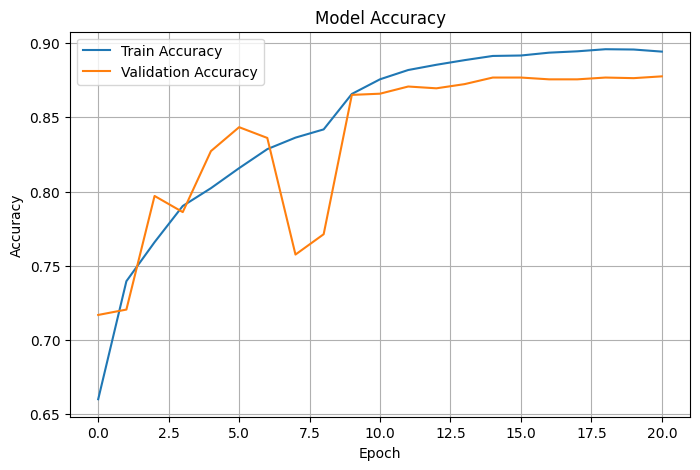

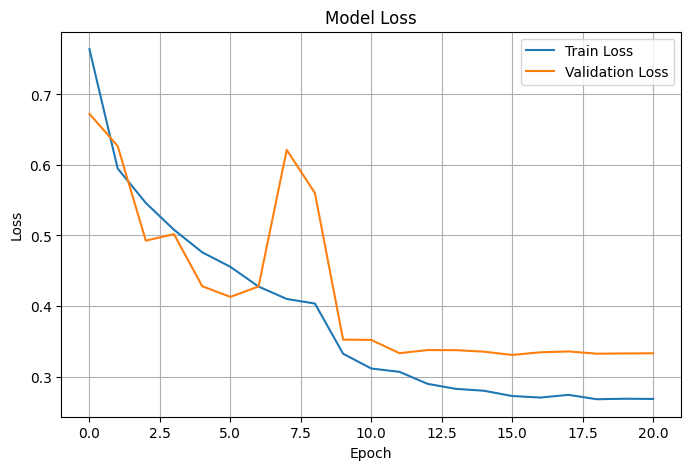

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Konversi Model

In [ ]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133852839098128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839098704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839099280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839100048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839099856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839098896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852839099472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852790015760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852790014416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133852790017296: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
%mkdir tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
class_labels = list(train_data.class_indices.keys())

with open("tflite/label.txt", "w") as f:
    for label in class_labels:
        f.write(label + "\n")


In [ ]:
!pip install tensorflowjs

!tensorflowjs_converter \
  --input_format=tf_saved_model \
  saved_model \
  tfjs_model/

2025-05-08 17:46:50.740065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746726410.771253   54491 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746726410.780195   54491 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-08 17:46:54.882932: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746726414.883083   54491 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving jambu_jambu_-_kantong_plastik_hd_putih_isi_50lembar_-uk_15-21-28-_full01_rqgdmjzi.webp to jambu_jambu_-_kantong_plastik_hd_putih_isi_50lembar_-uk_15-21-28-_full01_rqgdmjzi (6).webp


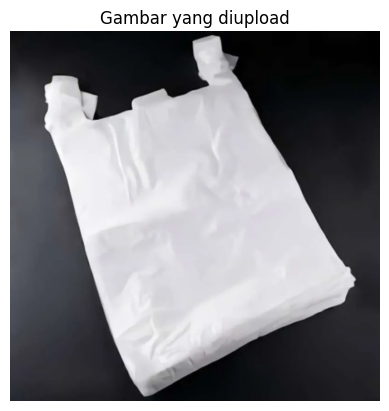

Prediksi kelas: domestic_textile


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

uploaded = files.upload()

interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

with open("label.txt", "r") as f:
    class_labels = [line.strip() for line in f.readlines()]

for file_name in uploaded.keys():
    img = Image.open(file_name)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar yang diupload")
    plt.show()

    # Preprocessing
    img = img.resize((150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = class_labels[np.argmax(output)]

    print("Prediksi kelas:", predicted_class)